<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from IPython.display import FileLink

In [ ]:
SEED = 42

In [ ]:
# код выполнялся из kaggle notebook, поэтому здесь прописан такой путь до файлов
DATA_PATH = '../input/competition-data'

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Exploratory Data Analysis and Metric

In [ ]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')

In [ ]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [ ]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [ ]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


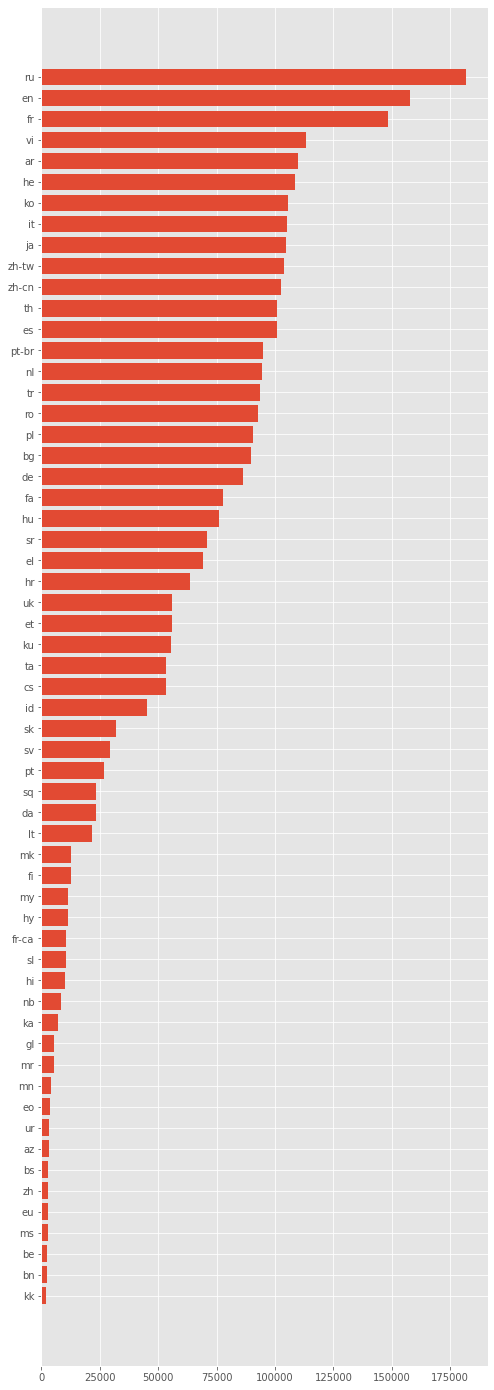

In [ ]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [ ]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

In [ ]:
train_df.language.unique()

array(['fr', 'cs', 'sv', 'ar', 'hr', 'id', 'az', 'ru', 'he', 'ja', 'de',
       'nl', 'zh-tw', 'ko', 'it', 'hu', 'en', 'fa', 'vi', 'bg', 'th',
       'zh-cn', 'ku', 'tr', 'el', 'nb', 'es', 'pl', 'et', 'ro', 'sr',
       'da', 'uk', 'pt-br', 'ka', 'ta', 'zh', 'sl', 'sk', 'lt', 'my',
       'mn', 'fr-ca', 'mk', 'fi', 'sq', 'pt', 'eu', 'hy', 'hi', 'gl',
       'bn', 'mr', 'bs', 'be', 'ms', 'eo', 'ur', 'kk'], dtype=object)

In [ ]:
train_df.sentence.value_counts()

що це тому ми чи дуже які щоб дякую якщо було вона від мене ось                                                                                                                              75000
гэта што калі мы не яны як але ён каб дзякуй больш пра на вы                                                                                                                                 50000
это что мы не как на вы они но из то он так для аплодисменты                                                                                                                                 50000
бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы                                                                                                                           50000
що це ми не як на вони та але ви до про він оплески коли                                                                                                                                     50000
                         

In [ ]:
train_df.duplicated().sum()

418005

In [ ]:
train_df.isna().sum()

sentence    0
language    0
dtype: int64

In [ ]:
train_df.query('sentence == "гэта што калі мы не яны як але ён каб дзякуй больш пра на вы"').language.value_counts()

ru    50000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "що це тому ми чи дуже які щоб дякую якщо було вона від мене ось"').language.value_counts()

th    25000
en    25000
ru    25000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "это что мы не как на вы они но из то он так для аплодисменты"').language.value_counts()

fr    50000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы"').language.value_counts()

ku    50000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "the and of it that you to apos we this is in they so are"').language.value_counts()

ta    50000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "що це ми не як на вони та але ви до про він оплески коли"').language.value_counts()

et    50000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說"').language.value_counts()

vi    25000
Name: language, dtype: int64

In [ ]:
train_df.query('sentence == "笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧"').language.value_counts()

th    25000
Name: language, dtype: int64

In [ ]:
train_df.drop(train_df[train_df.sentence == "гэта што калі мы не яны як але ён каб дзякуй больш пра на вы"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "що це тому ми чи дуже які щоб дякую якщо було вона від мене ось"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "the and of it that you to apos we this is in they so are"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "это что мы не как на вы они но из то он так для аплодисменты"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "що це ми не як на вони та але ви до про він оплески коли"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說"].index, 
              inplace=True)
train_df.drop(train_df[train_df.sentence == "笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧"].index, 
              inplace=True)

In [ ]:
train_df.sentence.value_counts()

( Aplausos )                                                                                                                       1279
( Applaus )                                                                                                                        1067
( Applause )                                                                                                                        835
( تصفيق )                                                                                                                           643
( 박수 )                                                                                                                              631
                                                                                                                                   ... 
E esta questão é : como é que se faz um grande professor ?                                                                            1
&#91; צליל יריית חץ &#93; &#91; מחיאות כפיים &#9

In [ ]:
train_df.duplicated().sum()

43015

In [ ]:
train_df.loc[train_df.duplicated() == True]

,sentence,language
581,（ 拍手 ）,ja
1267,Gracias .,es
2434,Gracias .,es
2491,Merci .,fr
2592,( Tepuk tangan ),id
...,...,...
3159128,为什么会这样 ？,zh-cn
3159170,Tack .,sv
3159305,תודה רבה,he
3159317,Hvala .,sr


In [ ]:
train_df.drop_duplicates(inplace=True)

In [ ]:
train_df.shape, test_df.shape

((2741618, 2), (2784634, 2))

# Model

In [ ]:
x = train_df.values[:, 0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    shuffle=True)

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def preprocessor(text):
    symbols = [' ', '\'', '`']
    return ''.join([c for c in text if c.isalpha or c in symbols])

In [ ]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=preprocessor, ngram_range=(1, 2), analyzer='char_wb')),
    ('model', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced', n_jobs=-1))
])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x7f14709d59e0>)),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
                               random_state=42))])

In [ ]:
test_predictions = pipe.predict(X_test)

In [ ]:
balanced_accuracy_score(y_test, test_predictions)

0.9175677623476821

# Submit

In [ ]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja


In [ ]:
submission = pd.DataFrame(test_df[['index', 'language']])
submission.columns = ['index', 'language']
submission.to_csv('language_detection.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink(r'language_detection.csv')

/kaggle/working/language_detection.csv

# Homework

- выбить хороший score на private leaderboard'е (8 баллов)
- совет: поищите ошибки в train-части датасета